In [1]:
import pandas as pd
import re
import math 
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
# Opens pickle file into a dataframe
file_path = 'whiskey_advocate.pickle'

df = pd.read_pickle(file_path)

In [3]:
df.head()

Rating                                               Name  \
0     97                     Johnnie Walker Blue Label, 40%   
1     97  Four Roses Limited Edition Small Batch (2013 R...   
2     97        Bowmore 46 year old (distilled 1964), 42.9%   
3     97  Parker's Heritage Collection, 'Golden Annivers...   
4     97      Black Bowmore 42 year old 1964 vintage, 40.5%   

                Category   Price         Reviewer         Date  \
0  Blended Scotch Whisky     225  Jonny McCormick  Spring 2018   
1      Bourbon/Tennessee      85     John Hansell  Winter 2013   
2     Single Malt Scotch   13500       Dave Broom    Fall 2012   
3      Bourbon/Tennessee  150.00     John Hansell    Fall 2009   
4     Single Malt Scotch    4500     John Hansell  Summer 2008   

                                         Description  
0  magnificently powerful and intense. caramels, ...  
1  a marriage of 13 and 18 year old bourbons. a m...  
2  there have been some legendary bowmores from t...  
3  this bottling celebrates master distiller park...  
4  what impresses me most is how this whisky evol...

In [4]:
# Converts the rating into an int
df['Rating'] = df['Rating'].astype(int)

In [5]:
# Functions to clean up data
def fix_prices(row):
    """
    Takes in a dataframe row and returns the price as a float
    with extraneous characters removed
    """
    is_a_set = False
    price = row['Price']
    price = price.split(' ')[0]
    if re.search('set', price) != None:
        is_a_set = True
    price= price.split('/')[0]
    price = re.sub('[$,]', '', price)
    if is_a_set:
        return float(price)/4
    return float(price)
def get_age(row):
    """
    Takes in a dataframe row and finds the age of the whiskey in the 
    Name column.  Returns that age as an int.  If there is no age
    given, returns zero.
    """
    index = row['Name'].find(' year old')
    if index>2:
        return int(row['Name'][index - 2: index])
    else:
        return 0
def get_abv(row):
    """
    Takes in a dataframe row and finds the ABV of the whiskey in the 
    Name column.  Returns that ABV as a float
    """
    abv = row['Name']
    if re.search('[%]', abv) == None:
        return 47
    abv = re.findall('(\d+?(:?\.\d+?)?%)', abv)[-1][0]
    abv = abv.strip('%')
    return float(abv)
def get_year (row):
    """
    Takes in a dataframe row and returns the year the review was made
    as an int
    """
    date = row['Date']
    return int(date.split(' ')[-1])
def get_gen_category (row):
    """
    Takes in a dataframe row and using the Category column, divides the
    whiskey up into several more general categories.  Returns the most
    relevant general category
    """
    cat = row['Category']
    if cat in ['American Malt Whiskey', 'American Whiskey', 'Blended American Whiskey', 'Craft Whiskey',
              'Single Malt American Whiskey']:
        return 'American'
    if cat in ['Blended Grain Scotch Whisky', 'Blended Malt Scotch Whisky', 'Single Grain Scotch', 
               'Single Malt Scotch']:
        return 'Scotch'
    if cat in ['Irish Single Malt','Irish Single Pot Still', 'Blended Irish Whiskey', 
               'Single Grain Irish Whiskey', 'Irish']:
        return 'Irish'
    if cat in ['Canadian']:
        return 'Candian'
    if cat in ['Bourbon/Tennessee']:
        return 'Bourbon'
    if cat in ['Rye Whiskey']:
        return 'Rye'
    if cat in ['Japanese Rice Whisky', 'Japanese Whisky']:
        return 'Japanese'
    if cat in ['Flavored Whisky & Liqueurs']:
        return 'Flavored'
    else:
        return 'Miscellaneous'

In [6]:
def get_adjective(row, string):
    """
    Takes in a dataframe row and returns 1 if the adjective is
    in the description, or 0 if it is not
    """
    if string in row['Description']:
        return 1
    else:
        return 0

In [7]:
# Makes new columns in dataframe with new variables
df['Age'] = df.apply(get_age, axis = 1)
df['Price_num'] = df.apply(fix_prices, axis = 1)
df['ABV'] = df.apply(get_abv, axis = 1)
df['Year'] = df.apply(get_year, axis = 1)
df['Gen_cat'] = df.apply(get_gen_category, axis = 1)


In [8]:
# Takes a list of adjectives (30) and makes a variable for each adjective where
# the value is 1 if the description contains that adjective and zero if not.
adj = ['tobacco', 'fruit', 'sweet', 'vanilla', 'chocolate', 'orange', 'cinnamon',  'smoke', 'pepper', 'harsh', 'sherry', 'caramel', 'toffee',
       'honey',  'citrus',  'peat', 'rich', 'leather', 'floral', 'complex', 'balance', 'coconut', 'spice',
       'cream', 'smooth', 'clove', 'nutmeg', 'tropical', 'fudge', 'peach', 'bright']
for word in adj:
    df[word] = df.apply(get_adjective, string = word, axis = 1)

In [10]:
ordered = df.groupby('Gen_cat').mean().sort_values(by = 'Rating', ascending=False).reset_index()
order_cat = ordered['Gen_cat'].unique().astype(list)

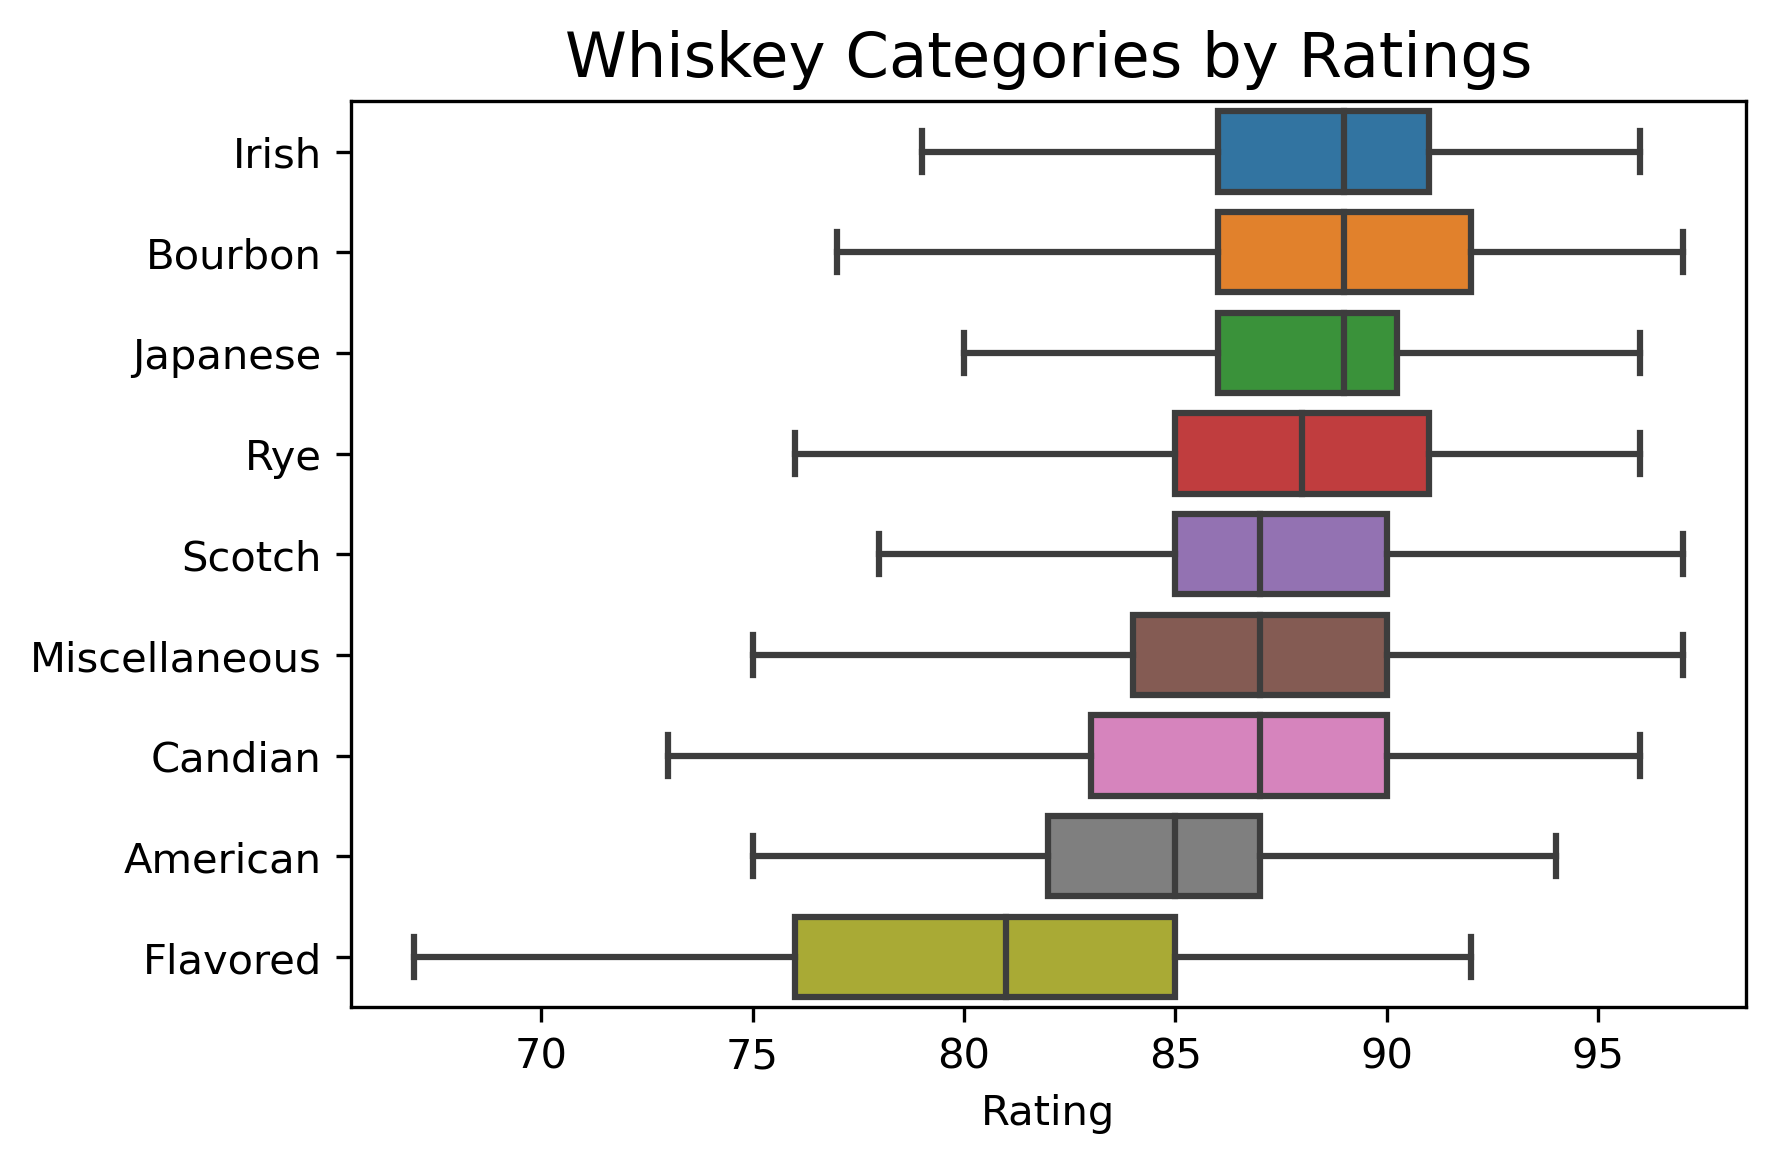

In [11]:
# Creates a boxplot showing the distribution of ratings for different
# general categories of whiskey.
fig, ax = plt.subplots(1, 1,  dpi=300)
sns.boxplot(y='Gen_cat', x='Rating', data=df, order=order_cat, showfliers=False)\
   .set_title('Whiskey Categories by Ratings', size=15);
ax.set_ylabel('');

In [12]:
# New variable that is the price of the whiskey in $1000
df['Price_k'] = df['Price_num']/1000

In [14]:
# Finds all the correlations between the variables.
df.corr()

Rating       Age  Price_num       ABV      Year   tobacco  \
Rating     1.000000  0.163664   0.089270  0.237411  0.176953  0.125069   
Age        0.163664  1.000000   0.138572  0.015849 -0.191793  0.013909   
Price_num  0.089270  0.138572   1.000000 -0.010880 -0.000898 -0.003057   
ABV        0.237411  0.015849  -0.010880  1.000000  0.013733  0.096645   
Year       0.176953 -0.191793  -0.000898  0.013733  1.000000  0.071340   
tobacco    0.125069  0.013909  -0.003057  0.096645  0.071340  1.000000   
fruit      0.156857  0.074990   0.011493  0.006040 -0.037759 -0.021676   
sweet     -0.045131 -0.067127  -0.024177 -0.023108  0.045720 -0.004425   
vanilla    0.102354  0.018156   0.013855 -0.026871 -0.076128 -0.003911   
chocolate  0.166034 -0.018086   0.021130  0.045709  0.261714  0.109359   
orange     0.107909  0.018676   0.019062 -0.051822  0.216620  0.010809   
cinnamon   0.126539 -0.047747  -0.022617  0.060777  0.069534  0.089060   
smoke      0.076213  0.016075   0.067017  0.068527 -0.006895  0.000112   
pepper     0.093329 -0.060853   0.002868 -0.003081  0.266633  0.015573   
harsh     -0.106489 -0.012877  -0.005557 -0.006154 -0.049927 -0.015287   
sherry     0.067467  0.088166   0.046393 -0.004896  0.005228 -0.023969   
caramel    0.070418 -0.036606  -0.018683  0.014160  0.034933  0.023953   
toffee     0.089755  0.117720  -0.007820 -0.009162 -0.120940  0.050769   
honey      0.073197  0.053610  -0.018143 -0.014418 -0.060979 -0.041195   
citrus     0.068170  0.021008  -0.007329 -0.032422  0.044315 -0.010982   
peat       0.057012 -0.007812   0.011043  0.080577 -0.049093 -0.008182   
rich       0.139487 -0.010614  -0.014387  0.020658 -0.019053  0.036165   
leather    0.138947  0.087625   0.022784  0.092142 -0.000999  0.266881   
floral     0.020168  0.022789  -0.007315 -0.032718  0.025844 -0.018076   
complex    0.162634  0.065065   0.005752  0.063435 -0.110521  0.055863   
balance    0.119419  0.050773  -0.019316  0.041485 -0.135445  0.065195   
coconut    0.056005  0.041790  -0.009541  0.012880 -0.071193 -0.005546   
spice      0.179446 -0.031843  -0.000149 -0.028423  0.194117  0.013565   
cream      0.045732 -0.015092  -0.027888 -0.066343 -0.025798 -0.038042   
smooth     0.007555 -0.034577   0.029906 -0.094490  0.042383 -0.026236   
clove      0.095830 -0.024619  -0.002558  0.046649  0.140856  0.028414   
nutmeg     0.085653 -0.000320  -0.010185  0.065960  0.046414  0.002722   
tropical   0.078986  0.044547   0.022558  0.000136  0.028428  0.003094   
fudge      0.058061  0.007589   0.002972 -0.008409  0.009345  0.008614   
peach      0.059969  0.021141   0.004942  0.005718  0.057081 -0.012518   
bright     0.040834 -0.001406   0.039560 -0.003225 -0.061420 -0.007360   
Price_k    0.089270  0.138572   1.000000 -0.010880 -0.000898 -0.003057   

              fruit     sweet   vanilla  chocolate  ...     spice     cream  \
Rating     0.156857 -0.045131  0.102354   0.166034  ...  0.179446  0.045732   
Age        0.074990 -0.067127  0.018156  -0.018086  ... -0.031843 -0.015092   
Price_num  0.011493 -0.024177  0.013855   0.021130  ... -0.000149 -0.027888   
ABV        0.006040 -0.023108 -0.026871   0.045709  ... -0.028423 -0.066343   
Year      -0.037759  0.045720 -0.076128   0.261714  ...  0.194117 -0.025798   
tobacco   -0.021676 -0.004425 -0.003911   0.109359  ...  0.013565 -0.038042   
fruit      1.000000 -0.024251  0.020848   0.004310  ...  0.089426  0.006806   
sweet     -0.024251  1.000000 -0.008472  -0.047965  ...  0.019752  0.019577   
vanilla    0.020848 -0.008472  1.000000  -0.038321  ...  0.091443  0.188448   
chocolate  0.004310 -0.047965 -0.038321   1.000000  ...  0.075012 -0.028554   
orange    -0.004885 -0.029809 -0.002850   0.177481  ...  0.103190  0.024552   
cinnamon  -0.019308 -0.016788  0.063256   0.051342  ...  0.114509 -0.014092   
smoke     -0.001100 -0.016612 -0.058058   0.010950  ... -0.105339 -0.063024   
pepper     0.006964  0.020718  0.009596   0.065551  ...  0.114208  0.032747   
harsh     -0.00

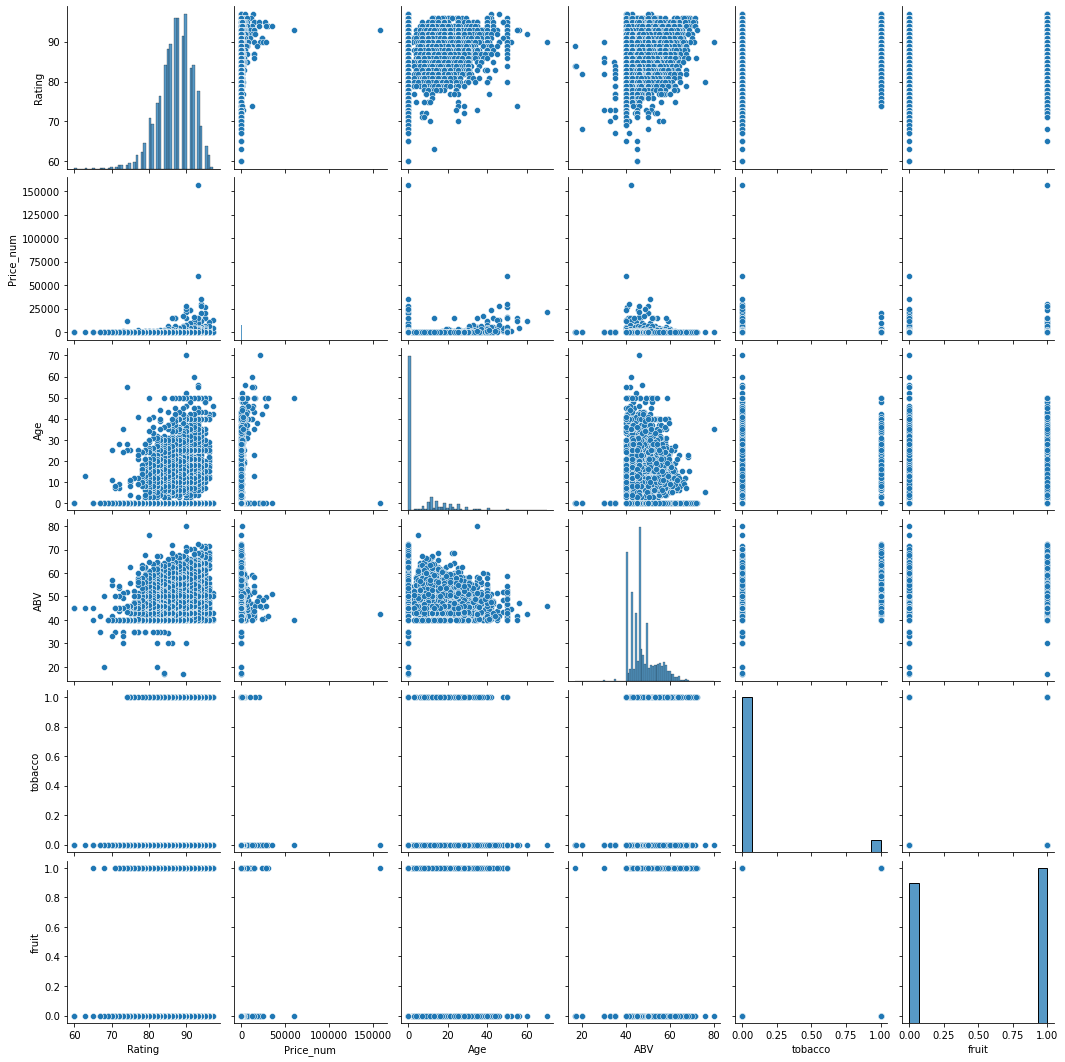

In [16]:
# Creats a pair plot to visualize relationships between variables
sns.pairplot(df[['Rating', 'Price_num', 'Age', 'ABV', 'tobacco', 'fruit']]);

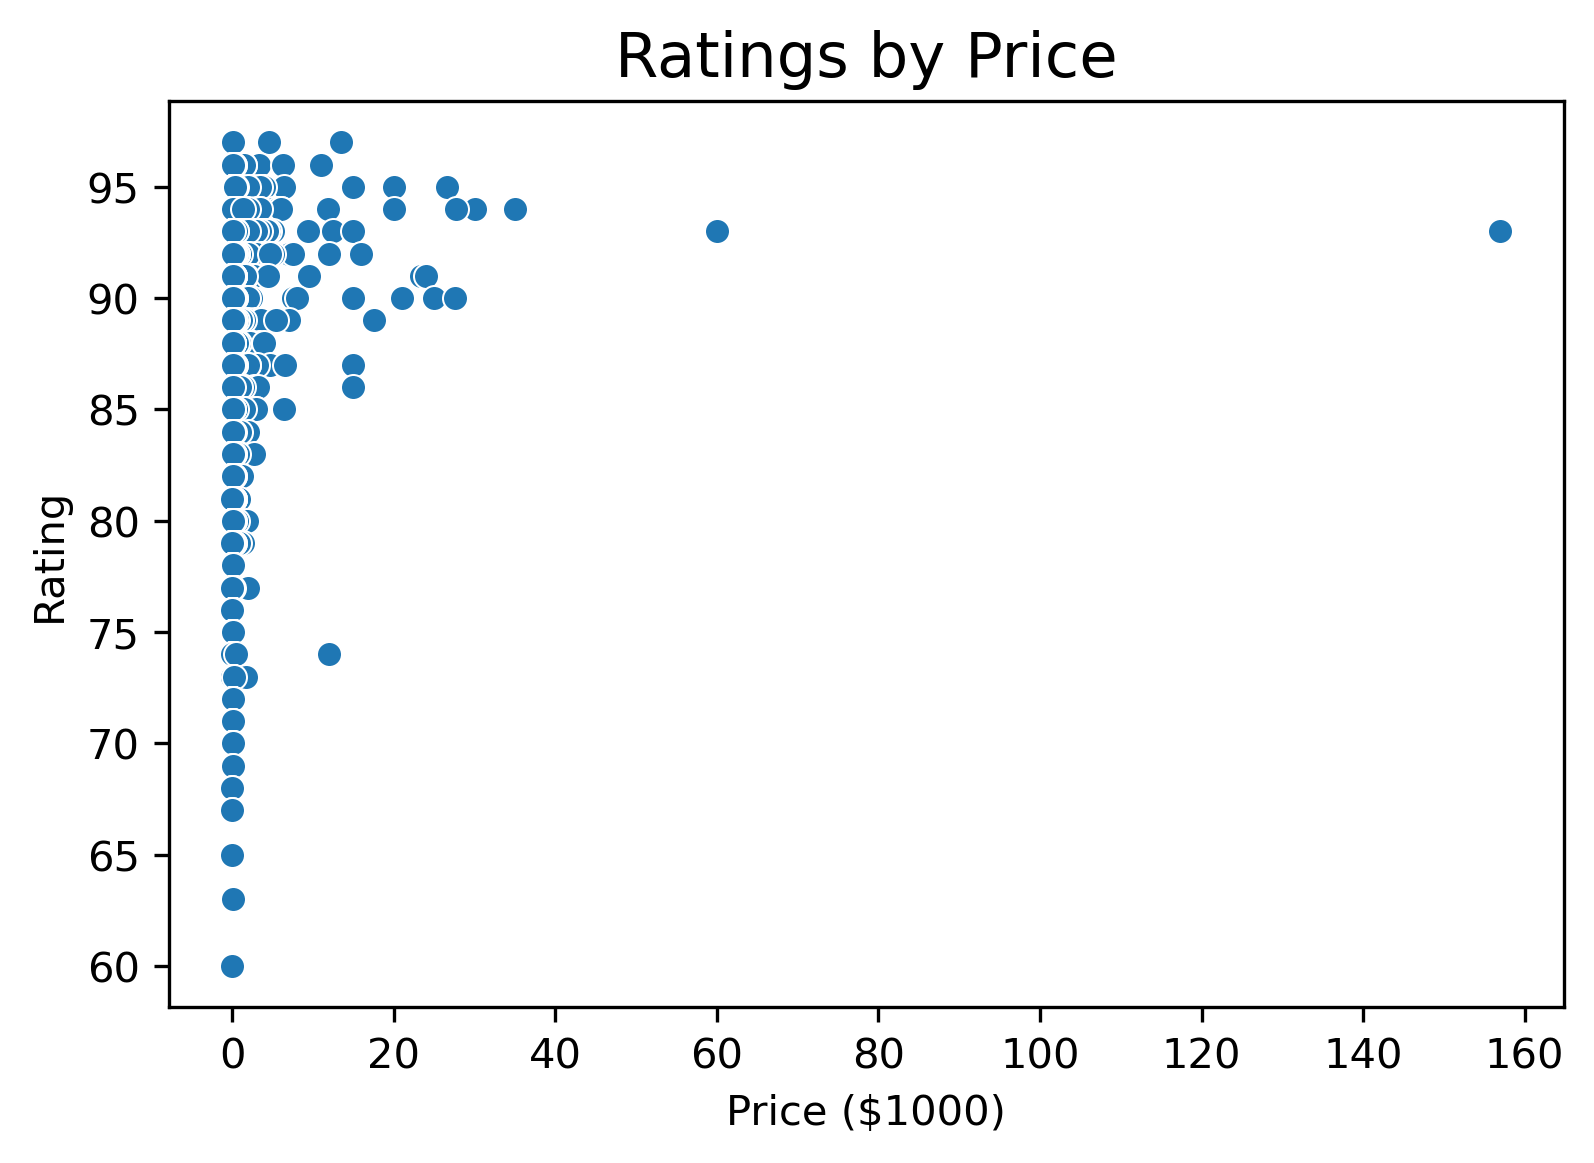

In [13]:
# Plots the ratings by price
fig, ax = plt.subplots(1, 1,dpi = 300)

sns.scatterplot(y='Rating', x='Price_k', data=df).set_title('Ratings by Price', size=15);
ax.set_ylabel('Rating');
ax.set_xlabel('Price ($1000)');
# plt.savefig('Ratings by Price')

In [17]:
# From the insights from the plots, do a bit of feature engineering to make variables more reasonable
df['Price_log'] = np.log(df['Price_num'])
df['Age_log'] = np.log(df['Age'].replace(0, np.nan))
df['Age_log'] = df['Age_log'].fillna(0)
df['ABV_log'] = np.log(df['ABV'])
df['Price_year'] = np.log(df['Price_num']*df['Year'])

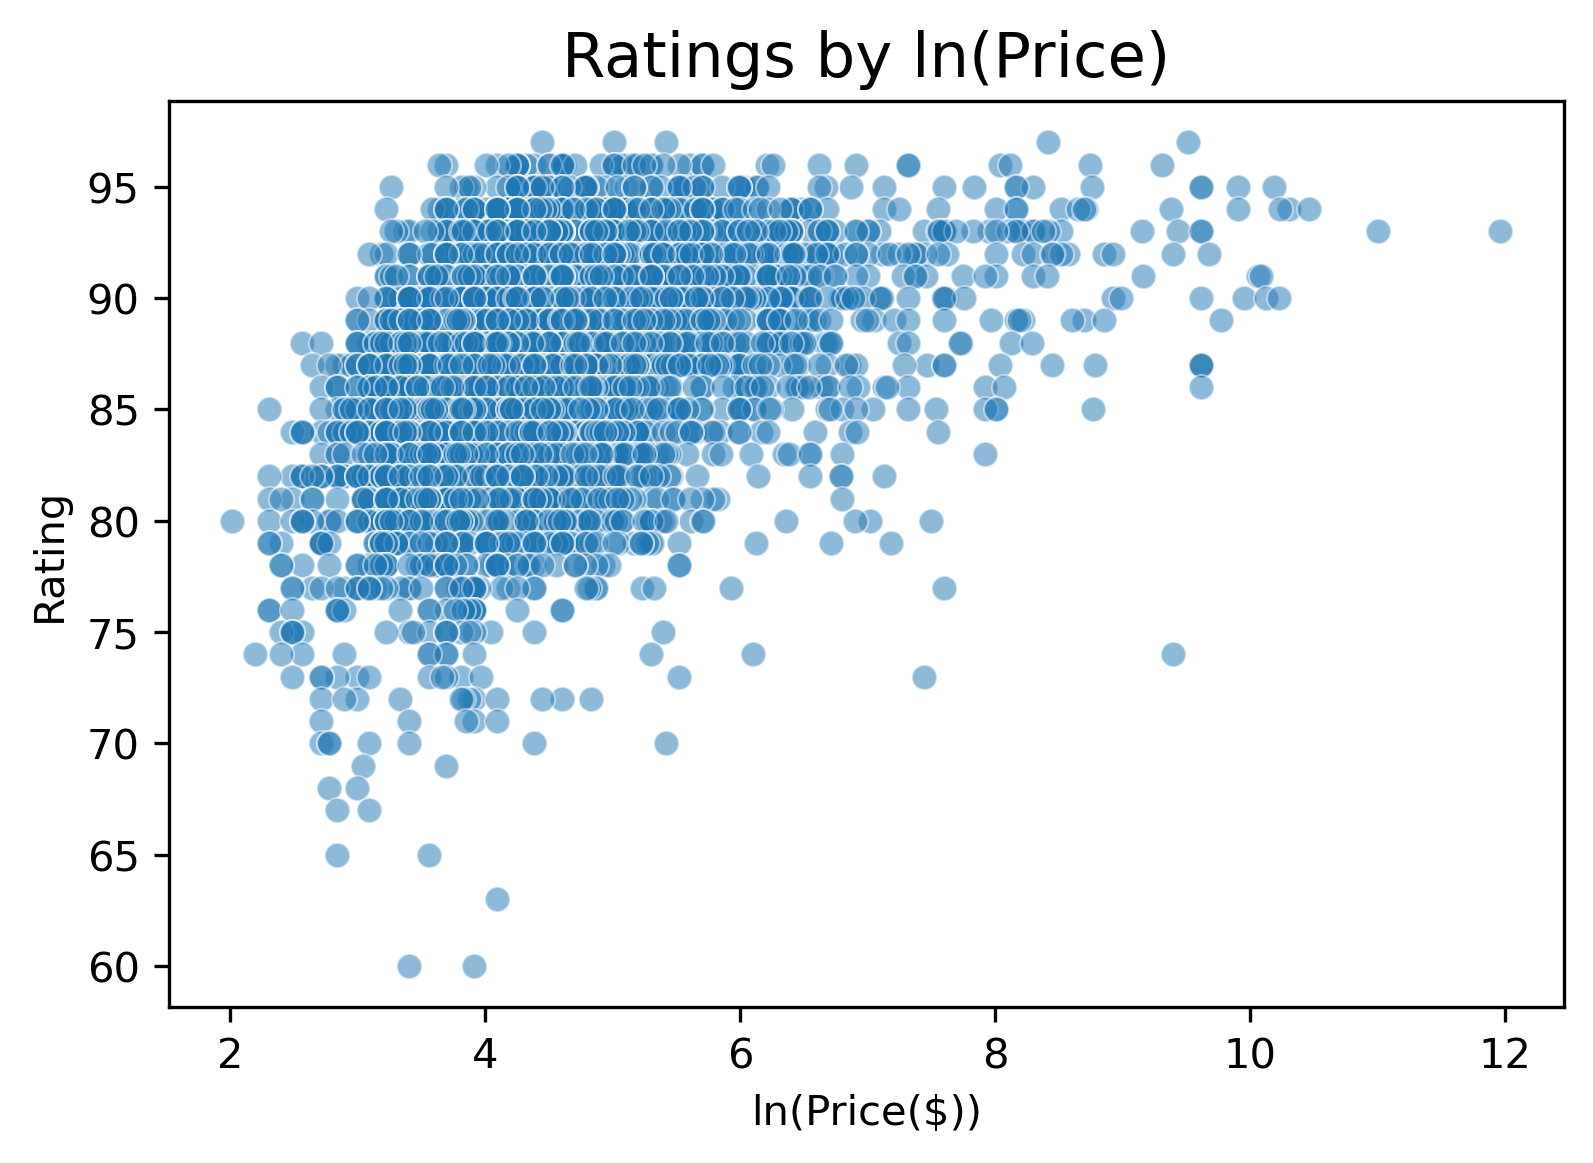

In [18]:
fig, ax = plt.subplots(1, 1,dpi = 300)

sns.scatterplot(y='Rating', x='Price_log', data=df,  alpha = .5).set_title('Ratings by ln(Price)', size=15);
ax.set_ylabel('Rating');
ax.set_xlabel('ln(Price($))');
# plt.savefig('Ratings by ln(Price)')

In [390]:
# Looks at the more specific categories and their average ratings.
df.groupby('Category').mean().sort_values(by = 'Rating', ascending=False)

Rating        Age   Price_num        ABV  \
Category                                                                        
Irish Single Pot Still            92.159091   4.545455  186.113636  50.645455   
Taiwanese Whisky                  90.115385   0.000000  201.230769  52.250000   
Irish Single Malt                 90.092308   9.446154  754.430769  44.624615   
Japanese Rice Whisky              90.000000   0.000000  115.000000  41.100000   
Blended Grain Scotch Whisky       89.625000   2.625000  175.750000  45.975000   
World Whisky                      89.136364   3.318182   97.363636  47.363636   
Indian Whisky                     89.071429   0.928571  118.333333  51.775714   
Light Whiskey                     89.000000   0.000000  100.000000  46.000000   
Dutch                             88.700000   4.100000   85.300000  46.850000   
Bourbon/Tennessee                 88.451527   3.944223   76.013280  50.034309   
English Grain Whisky & Spirit     88.333333   0.000000   63.000000  43.666667   
Blended Malt Scotch Whisky        88.121547   4.618785  127.806630  46.392265   
Japanese Whisky                   88.118182   4.281818  184.559091  47.040000   
Rye Whiskey                       87.956522   4.278261   77.591304  49.783000   
Irish                             87.898990   6.767677  125.909091  46.041414   
Welsh Whisky                      87.800000   1.100000   97.500000  47.170000   
French Whisky                     87.760000   0.200000   77.820000  45.762000   
Blended Scotch Whisky             87.731343   9.417910  842.208955  42.662687   
Blended Irish Whiskey             87.366667   1.511111  129.744444  42.947778   
Single Grain Irish Whiskey        87.142857   5.571429   63.285714  44.714286   
Single Malt Scotch                87.063340  11.205854  573.713052  48.418493   
Netherlands Whisky                87.000000   0.000000   35.000000  46.000000   
Single Malt American Whiskey      86.985075   0.417910  116.686567  48.114179   
Single Malt Swedish Whisky        86.833333   0.000000  112.833333  48.697619   
Multinational Whisky              86.666667   1.111111   60.666667  45.533333   
Single Malt French Whisky         86.666667   3.333333   86.222222  47.344444   
Single Malt Finnish Whisky        86.600000   2.000000   94.400000  43.000000   
Wheat Whiskey                     86.583333   3.166667   45.833333  45.991667   
Single Grain Scotch               86.382353  22.784314  255.254902  50.217647   
Canadian                          86.340824   4.441948   64.207865  43.978464   
Miscellaneous                     85.750000   0.843750  222.437500  49.920313   
Australian Whisky                 85.630435   0.152174  154.695652  49.015217   
Single Malt English Whisky        85.566667   1.266667  103.733333  49.616667   
Single Malt Belgian Whisky        85.500000   1.500000   52.500000  43.000000   
Corn Whiskey                      85.400000   0.000000   45.600000  48.980000   
Blended American Whiskey          85.066667   0.000000   52.600000  47.476667   
American Malt Whiskey             85.000000   1.142857   70.714286  45.657143   
Liechtenstein                     85.000000   2.500000  149.000000  43.125000   
American Whiskey                  85.000000   1.878788   58.242424  47.627273   
Austrian Whisky                   84.363636   4.363636   79.090909  44.245455   
Danish                            84.250000   0.000000  248.875000  51.187500   
Swiss                             84.090909   0.272727   84.090909  47.136364   
Icelandic Whisky and Malt Spirit  84.000000   0.000000   61.000000  47.000000   
Craft Whiskey                     83.745810   0.108939   53.351955  46.494609   
South African Whisky              83.600000   1.000000   60.800000  44.400000   
Unspecified Single Malt           83.428571   4.857143   88.857143  45.714286   
Blended French Whisky             83.333333   0.000000   38.000000  41.933333   
New Zealand                       82.818182  11.545455  109.272727  

In [20]:
lr = LinearRegression()

In [22]:
# Possible interaction variable that turned out not to be useful
df['Peat_scotch'] = df['peat']*(df['Gen_cat'] == 'Scotch')

In [23]:
# Takes the variables, splits them up into test, train, and validate
# sets and fits a linear regression model

X = df[['Category', 'Price_log', 'Year', 'Price_num', 'Reviewer', 'ABV',
        'Age_log', 'Price_year', 'tobacco', 'fruit', 'sweet', 
        'vanilla', 'chocolate','cinnamon', 'smoke', 
        'pepper', 'harsh', 'sherry', 'caramel', 'toffee','honey',  
        'citrus', 'peat', 'rich', 'leather', 'floral', 'complex', 
        'balance', 'coconut', 'cream', 'smooth', 'clove', 'nutmeg', 'tropical', 
        'fudge', 'peach', 'bright', 'spice']]

X = pd.get_dummies(X, drop_first = True)

y = df['Rating']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state = 9)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state = 3)

# Fit the model 
lr.fit(X_train, y_train)

# Score the model (with R^2)
print('Train:', lr.score(X_train, y_train))
print('Test:', lr.score(X_test, y_test))

Train: 0.42695792002277755
Test: 0.40572162060550787


In [24]:
list(zip(X_train.columns, lr.coef_))

[('Price_log', 269017.5218420675),
 ('Year', 134.00095549187597),
 ('Price_num', -5.663867341354489e-05),
 ('ABV', 0.07302339235320687),
 ('Age_log', 0.15369853681477252),
 ('Price_year', -269016.1884583095),
 ('tobacco', 0.4141576352485572),
 ('fruit', 0.4253584674879676),
 ('sweet', -0.012393809402055922),
 ('vanilla', 0.475961042326162),
 ('chocolate', 0.5613306867894607),
 ('cinnamon', 0.8133434089695584),
 ('smoke', 0.5885564060522483),
 ('pepper', 0.2279577929930383),
 ('harsh', -3.6905277029444505),
 ('sherry', 0.4355990684283597),
 ('caramel', 0.4066095605097644),
 ('toffee', 0.4848697160755364),
 ('honey', 0.5141064757377194),
 ('citrus', 0.25600512953758425),
 ('peat', 0.8361355173674951),
 ('rich', 1.1343626260451742),
 ('leather', 0.6877263242217282),
 ('floral', 0.2584591726421763),
 ('complex', 1.356975109023125),
 ('balance', 0.759134504990044),
 ('coconut', 0.39919827957950815),
 ('cream', 0.4548941929418504),
 ('smooth', 0.555498296827821),
 ('clove', 0.393118348325174

In [58]:
# Gets the R^2 score for the validation set
# Did this at the very end, after all feature engineering
# was complete.
print('Validation:', lr.score(X_val, y_val))

Validation: 0.2865417317859774


In [32]:
# Gets root mean squared error
y_pred = lr.predict(X_test)
rmse = (mean_squared_error(y_test, y_pred))**(1/2)
print('Root mean squared error:', rmse)

Root mean squared error: 3.6549282941357655


In [33]:
result = pd.DataFrame()
result['Actual'] = y_test
result['Predicted'] = y_pred

In [34]:
# Gets mean absolute error
result['Error'] = abs(result['Actual'] - result['Predicted'])
result['Error'].mean()

2.7433821440230504

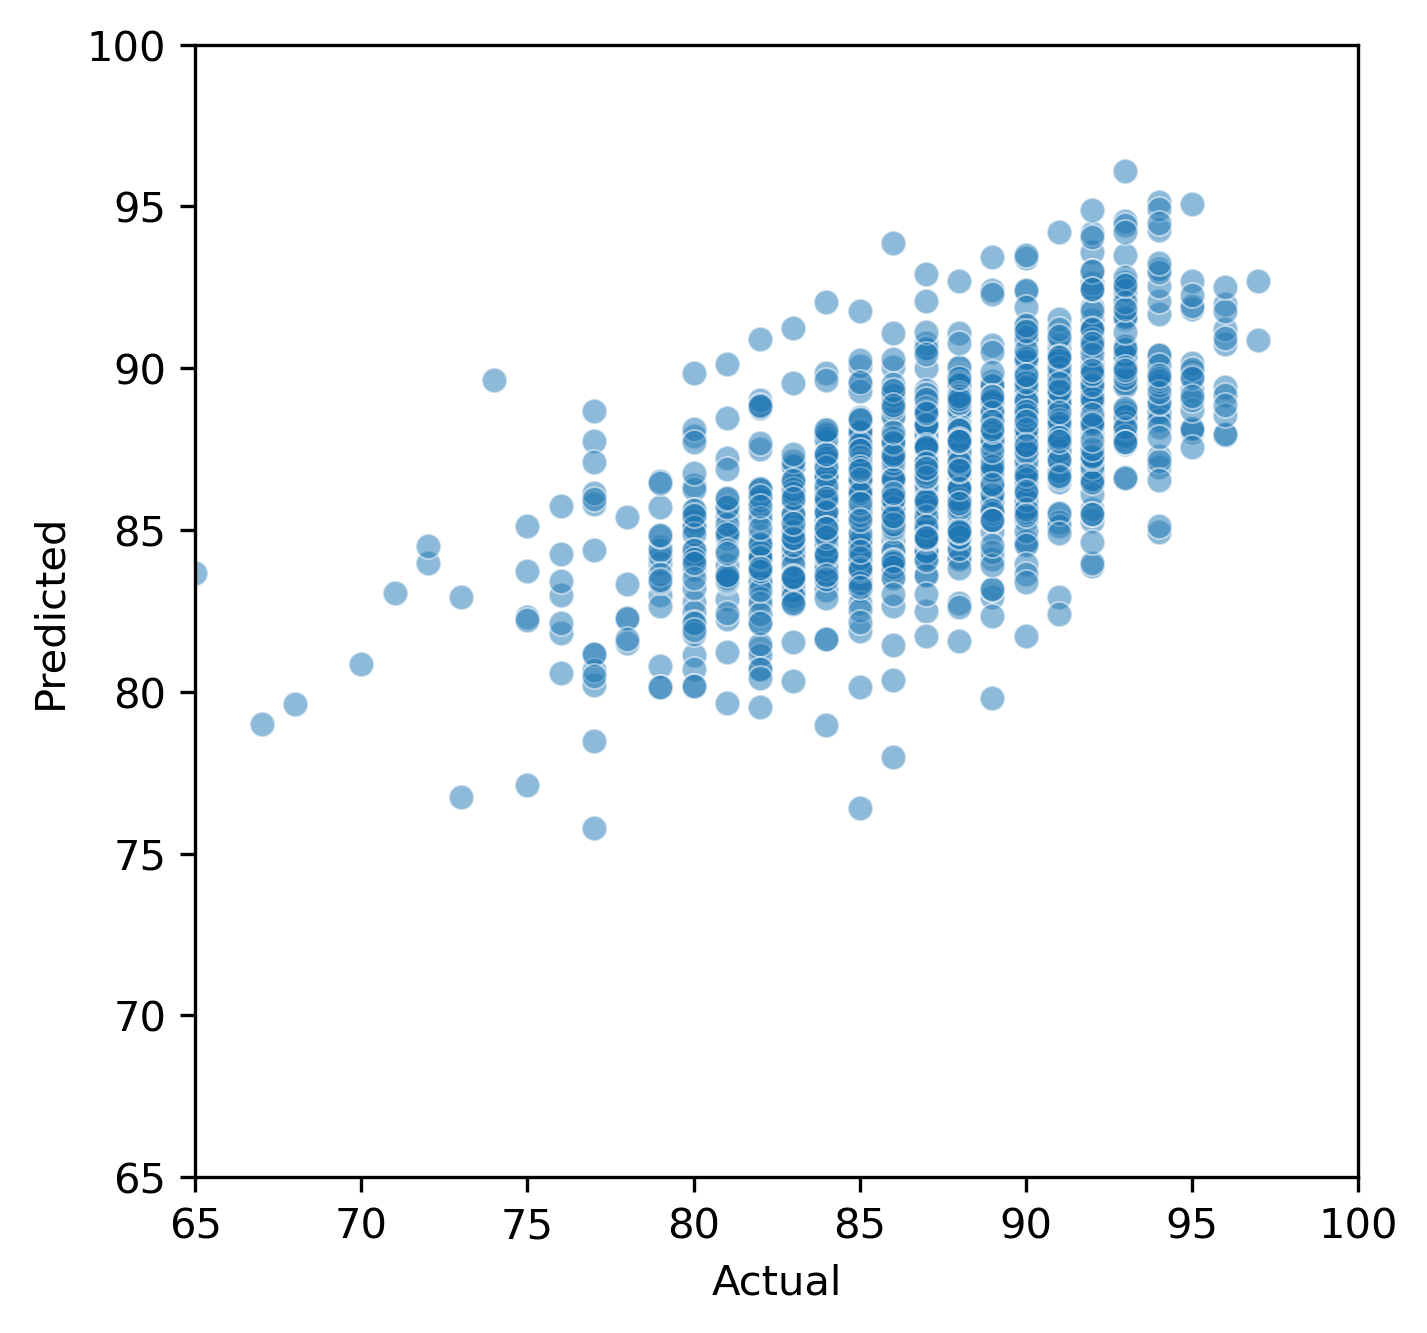

In [36]:
# Plots the predicted ratings vs actual ratings
slope, intercept, r_value, p_value, std_err = stats.linregress(result['Actual'],result['Predicted'])

fig, ax = plt.subplots(1, 1,figsize = (5,5), dpi = 300)
sns.scatterplot(x = 'Actual', y = 'Predicted', data = result, alpha = .5);
plt.xlim(65, 100);
plt.ylim(65, 100);
#plt.savefig('Actual Vs Predicted')

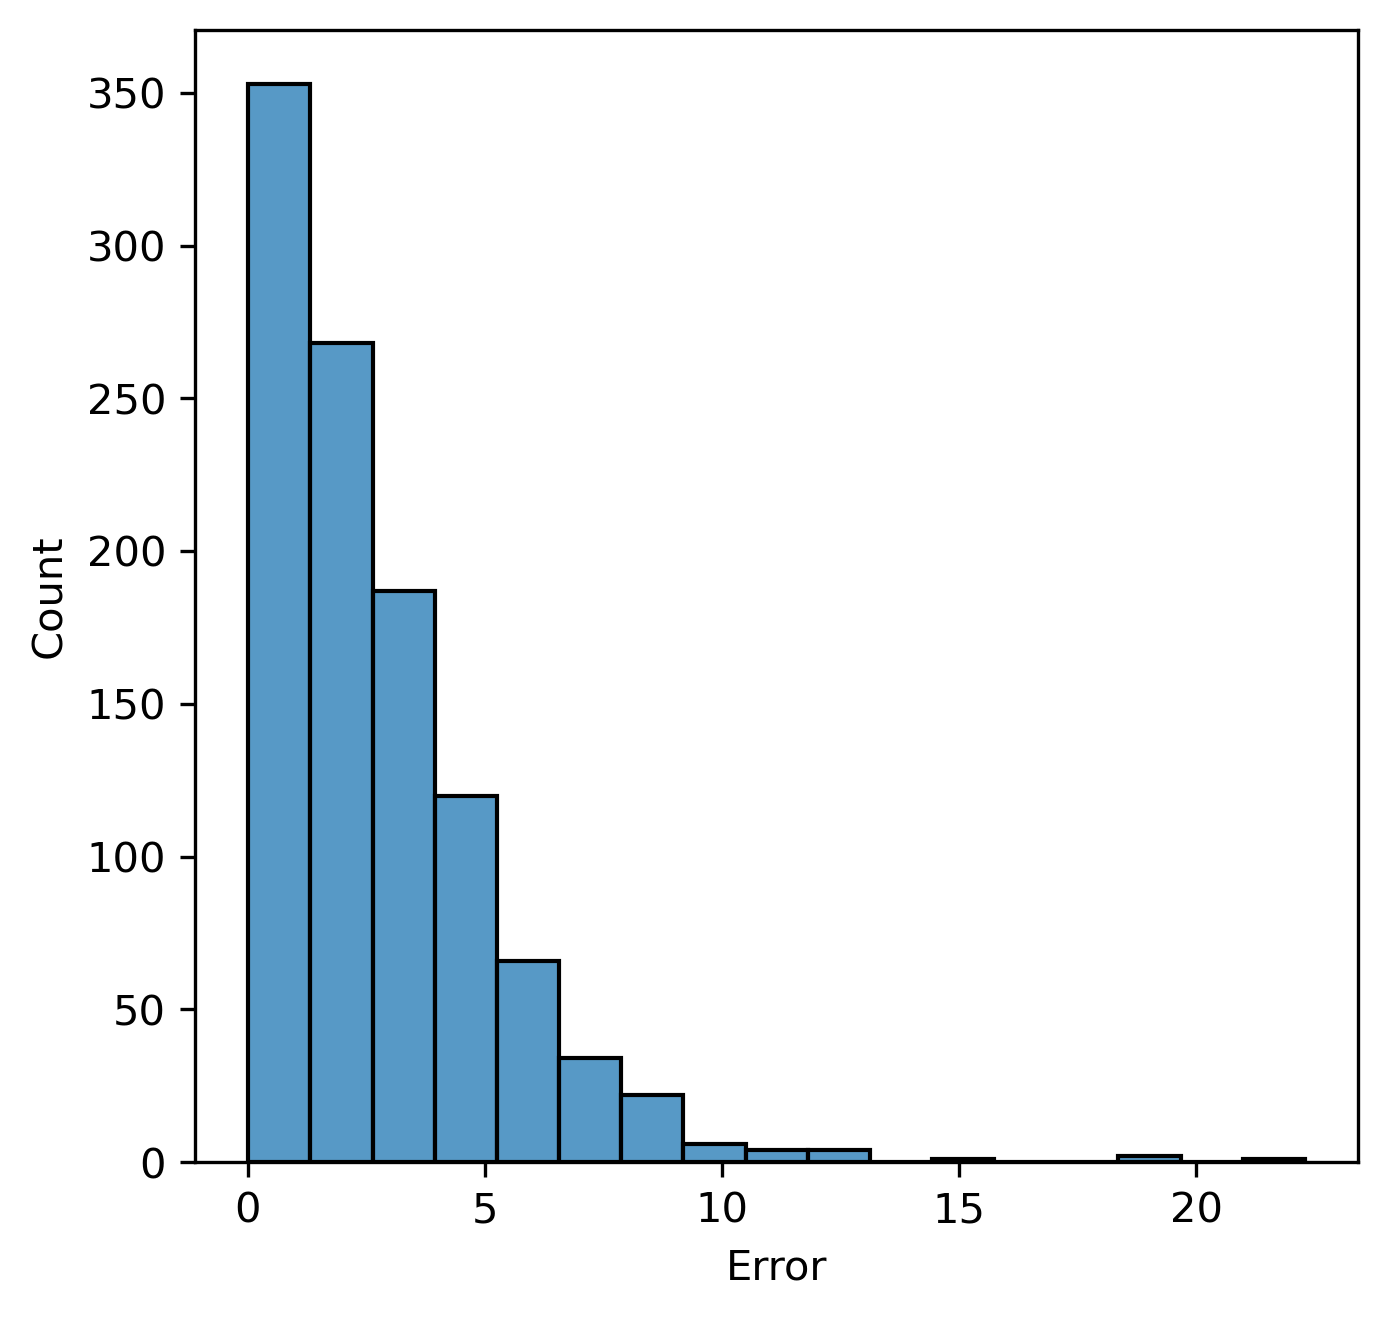

In [37]:
# Plots the distribution of the errors
fig, ax = plt.subplots(1, 1,figsize = (5,5), dpi = 300)
sns.histplot(data=result, x='Error', bins=17);
#plt.savefig('Error Distribution')

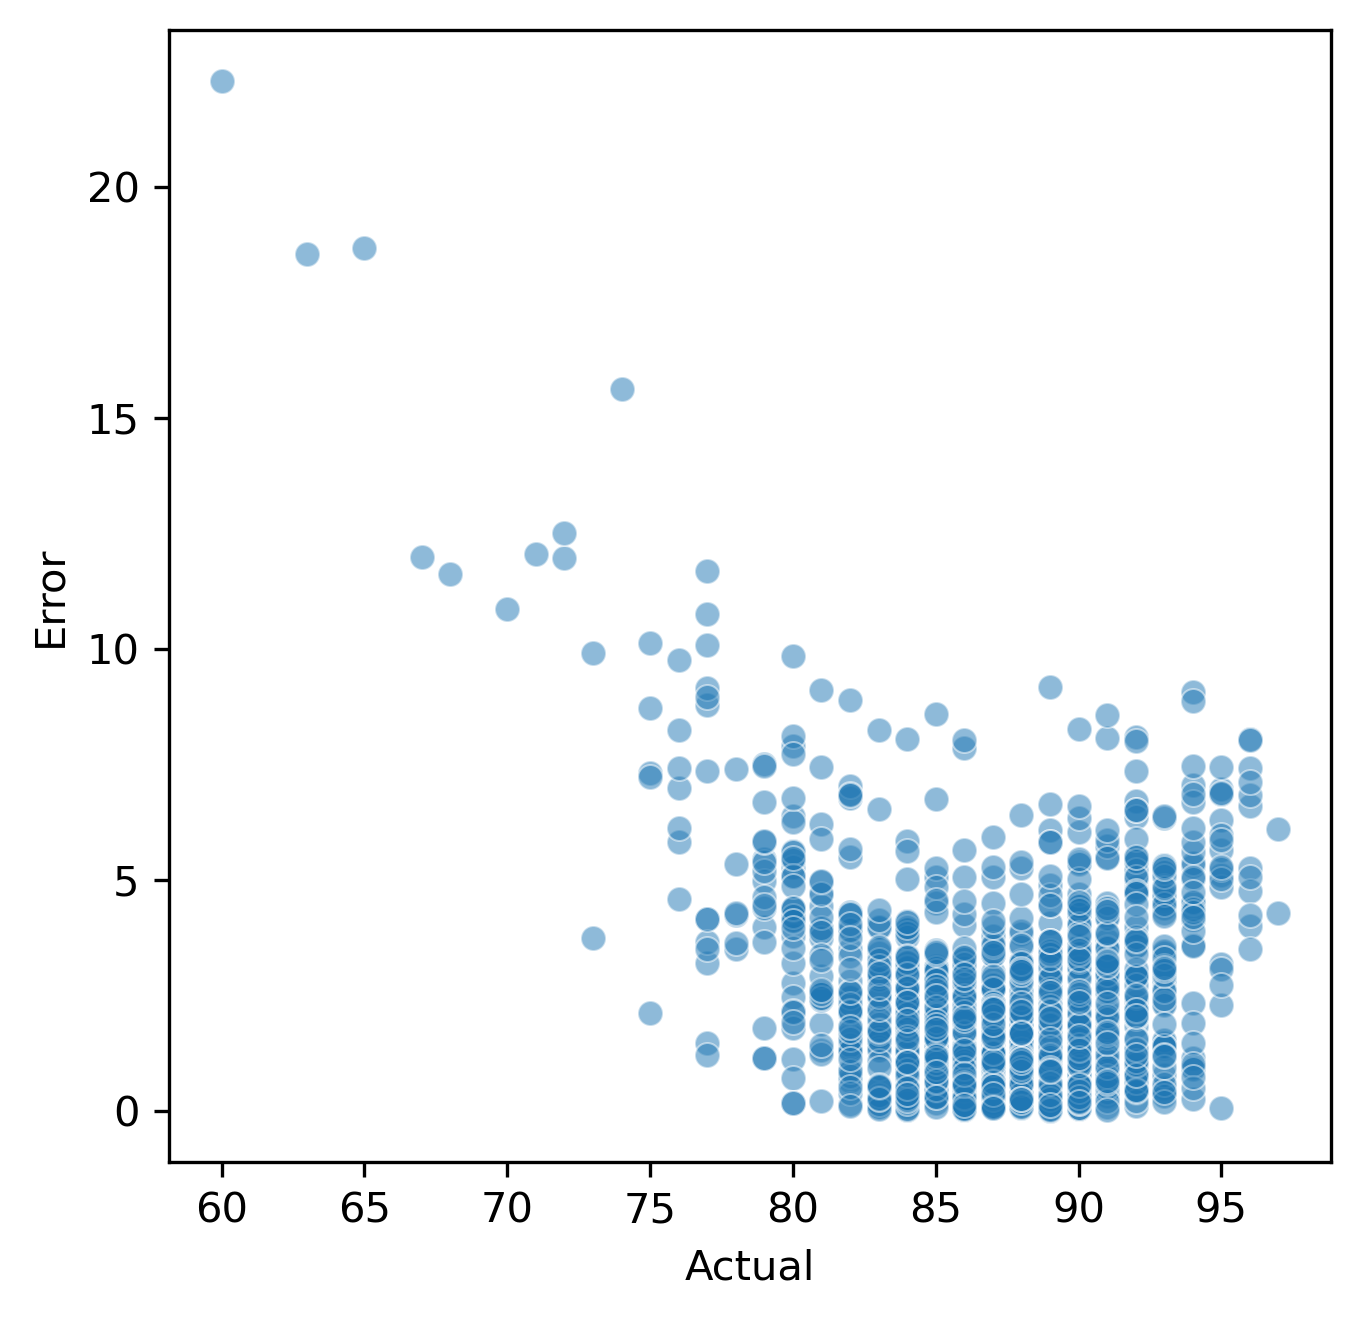

In [40]:
# Plots residuals
fig, ax = plt.subplots(1, 1,figsize = (5,5), dpi = 300)
sns.scatterplot(x = 'Actual', y = 'Error', data = result, alpha = .5);

In [25]:
# Fits data into an OLS model
import statsmodels.api as sm
lm_2 = sm.OLS(y, X) 

lm_2 = lm_2.fit()

# summarize our model
lm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Rating   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          2.677e+04
Date:                Mon, 12 Oct 2020   Prob (F-statistic):                        0.00
Time:                        07:40:18   Log-Likelihood:                         -11310.
No. Observations:                4270   AIC:                                  2.282e+04
Df Residuals:                    4169   BIC:                                  2.346e+04
Df Model:                         101                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Price_log                                    72.5159      7.562      9.589      0.000      57.690      87.341
Year                                          0.3049      0.029     10.689      0.000       0.249       0.361
Price_num                                 -6.725e-05   2.07e-05     -3.247      0.001      -0.000   -2.66e-05
ABV                                           0.0780      0.009      8.217      0.000       0.059       0.097
Age_log                                       0.1320      0.045      2.910      0.004       0.043       0.221
Price_year                                  -71.1097      7.564     -9.401      0.000     -85.940     -56.279
tobacco                                       0.2911      0.223      1.307      0.191      -0.146       0.728
fruit                                         0.5426      0.115      4.716      0.000       0.317       0.768
sweet                                        -0.0188      0.112     -0.168      0.867      -0.239       0.201
vanilla                                       0.5306      0.123      4.298      0.000       0.289       0.773
chocolate                                     0.5515      0.139      3.969      0.000       0.279       0.824
cinnamon                                      0.6817      0.149      4.564      0.000       0.389       0.975
smoke                                         0.6449      0.165      3.918      0.000       0.322       0.968
pepper                                        0.2873      0.132      2.174      0.030       0.028       0.546
harsh                                        -5.2566      1.067     -4.926      0.000      -7.349      -3.165
sherry                                        0.4130      0.170      2.431      0.015       0.080       0.746
caramel                                       0.3556      0.140      2.541      0.011       0.081       0.630
toffee                                        0.4595      0.153      3.011      0.003       0.160       0.759
honey                                         0.4312      0.134      3.224      0.001       0.169       0.693
citrus                                        0.2193      0.157      1.400      0.162      -0.088       0.526
peat                                          0.7368      0.187      3.948      0.000       0.371       1.103
rich                                          1.2627      0.145      8.709      0.000       0.978       1.547
leather                                       0.7096      0.188      3.779      0.000       0.341       1.078
floral                                        0.6512      0.199      3.265      0.001       0.260       1.042
complex       

In [41]:
# Adds polynomial features to regression. Results in severe overfitting
p = PolynomialFeatures(degree = 2)
X_poly = p.fit_transform(X_train)
X_poly_test = p.fit_transform(X_test)
lr_full = LinearRegression()
lr_full.fit(X_poly,
            y_train)
print('Train:', lr_full.score(X_poly, y_train))
print('Test:', lr_full.score(X_poly_test, y_test))

Train: 0.7535527038869653
Test: -7193169.613864383


In [42]:
# Ran Lasso regularized regression to find extraneous variables to remove.
std = StandardScaler()
std.fit(X_train)
X_std = std.transform(X_train)
X_std_test = std.transform(X_test)

lasso_model = LassoCV(cv=5)
lasso_model.fit(X_std, y_train)
print('Train:', lasso_model.score(X_std, y_train))
print('Test:', lasso_model.score(X_std_test, y_test))

#lr_full = LinearRegression()
#lr_full.fit(X_poly, y_train)
#print('Train:', lr_full.score(X_poly, y_train))
#print('Test:', lr_full.score(X_poly_test, y_test))

Train: 0.3932570198996157
Test: 0.3659914128000227


In [43]:
y_pred = lasso_model.predict(X_std_test)
rmse = (mean_squared_error(y_test, y_pred))**(1/2)

In [44]:
print(rmse)

3.775126125890857


In [45]:
list(zip(X_train.columns, lasso_model.coef_))

[('Price_log', 1.2701807009966746),
 ('Year', 0.9266096111161592),
 ('Price_num', -0.07749698041778791),
 ('ABV', 0.4430653172319224),
 ('Age_log', 0.17718519593235166),
 ('Price_year', 0.016467518798904072),
 ('tobacco', 0.06664868750673693),
 ('fruit', 0.22900355511097822),
 ('sweet', -0.0),
 ('vanilla', 0.21385268485956566),
 ('chocolate', 0.18689053552824378),
 ('cinnamon', 0.2632642958314713),
 ('smoke', 0.16029406151229958),
 ('pepper', 0.09827960337894437),
 ('harsh', -0.13291450097396668),
 ('sherry', 0.030515583657048415),
 ('caramel', 0.0901048457224833),
 ('toffee', 0.14853056132282236),
 ('honey', 0.16785929842888977),
 ('citrus', 0.06207105401976779),
 ('peat', 0.26825641013520823),
 ('rich', 0.41889301978728544),
 ('leather', 0.20089124671635092),
 ('floral', 0.061155336359520085),
 ('complex', 0.4508828575749008),
 ('balance', 0.27774350115657187),
 ('coconut', 0.04241312167133875),
 ('cream', 0.14092808573179452),
 ('smooth', 0.07962353291820189),
 ('clove', 0.083481797

In [46]:
df.mean()

Rating           87.033533
Age               6.947359
Price_num       328.252154
ABV              47.639652
Year           2014.197265
tobacco           0.072124
fruit             0.524541
sweet             0.475459
vanilla           0.378232
chocolate         0.259273
orange            0.200075
cinnamon          0.193331
smoke             0.176471
pepper            0.276321
harsh             0.002997
sherry            0.138816
caramel           0.216561
toffee            0.172724
honey             0.233983
citrus            0.143687
peat              0.134695
rich              0.164856
leather           0.104534
floral            0.082803
complex           0.113151
balance           0.162982
coconut           0.064631
spice             0.427876
cream             0.179655
smooth            0.067816
clove             0.092544
nutmeg            0.062570
tropical          0.052079
fudge             0.052829
peach             0.088048
bright            0.044399
Price_k           0.328252
P

In [49]:
descript_dict = dict()
descript_list = df['Description']

In [48]:
# Finds the most common words in the descriptions for all whiskies
descript_dict = dict()
descript_list = df['Description']
for description in descript_list:
    for word in description.split():        
        word = re.sub(r'\W+', '', word).lower()
        if word in descript_dict and len(word) > 3:
            descript_dict[word] += 1
        elif len(word) > 3:
            descript_dict[word] = 1

In [49]:
sort_dict = sorted(descript_dict.items(), key=lambda x: x[1], reverse=True)
sort_dict

[('with', 8440),
 ('this', 4105),
 ('finish', 3452),
 ('palate', 2566),
 ('nose', 2509),
 ('notes', 2294),
 ('vanilla', 2287),
 ('sweet', 2253),
 ('fruit', 1872),
 ('whisky', 1770),
 ('chocolate', 1680),
 ('more', 1628),
 ('from', 1520),
 ('spice', 1480),
 ('that', 1465),
 ('orange', 1244),
 ('malt', 1195),
 ('spices', 1179),
 ('pepper', 1176),
 ('smoke', 1157),
 ('cinnamon', 1126),
 ('caramel', 1104),
 ('sherry', 1066),
 ('whiskey', 1055),
 ('very', 1020),
 ('toffee', 1001),
 ('fruits', 992),
 ('bourbon', 990),
 ('honey', 967),
 ('some', 966),
 ('year', 925),
 ('flavors', 922),
 ('dark', 922),
 ('spicy', 900),
 ('dried', 851),
 ('light', 834),
 ('bottles', 821),
 ('apple', 811),
 ('citrus', 810),
 ('casks', 806),
 ('years', 776),
 ('then', 753),
 ('ginger', 751),
 ('peat', 749),
 ('water', 748),
 ('like', 748),
 ('hint', 743),
 ('soft', 740),
 ('rich', 734),
 ('long', 728),
 ('sweetness', 723),
 ('cask', 696),
 ('black', 686),
 ('lemon', 676),
 ('fresh', 667),
 ('wood', 646),
 ('than'

In [50]:
# Gets most common words in descriptions for highly rating whiskies
descript_dict_high_rating = dict()
for description in descript_list[:150]:
    for word in description.split():
        word = re.sub(r'\W+', '', word).lower()
        if word in descript_dict_high_rating and len(word) > 3:
            descript_dict_high_rating[word] += 1
        elif len(word) > 3:
            descript_dict_high_rating[word] = 1

In [51]:
sort_dict_high = sorted(descript_dict_high_rating.items(), key=lambda x: x[1], reverse=True)
sort_dict_high

[('with', 208),
 ('this', 138),
 ('finish', 88),
 ('vanilla', 80),
 ('notes', 69),
 ('fruit', 69),
 ('cinnamon', 69),
 ('very', 56),
 ('whiskey', 54),
 ('palate', 53),
 ('whisky', 52),
 ('spice', 50),
 ('toffee', 49),
 ('caramel', 46),
 ('sweet', 46),
 ('from', 43),
 ('that', 43),
 ('years', 42),
 ('spices', 41),
 ('nose', 41),
 ('more', 40),
 ('bourbon', 40),
 ('year', 39),
 ('smoke', 38),
 ('polished', 38),
 ('leather', 35),
 ('tobacco', 34),
 ('complex', 34),
 ('still', 32),
 ('rich', 31),
 ('dried', 30),
 ('citrus', 30),
 ('fruits', 29),
 ('mint', 29),
 ('dark', 29),
 ('chocolate', 29),
 ('sweetness', 28),
 ('than', 28),
 ('honey', 28),
 ('hint', 27),
 ('long', 27),
 ('balance', 27),
 ('bottles', 26),
 ('balanced', 25),
 ('peat', 25),
 ('flavors', 23),
 ('release', 23),
 ('syrup', 23),
 ('silky', 21),
 ('soft', 21),
 ('like', 21),
 ('candied', 21),
 ('apple', 20),
 ('orange', 20),
 ('classic', 20),
 ('which', 20),
 ('quite', 20),
 ('nougat', 20),
 ('collection', 20),
 ('coconut', 2

In [52]:
# Gets all scotch whiskey
scotch = df[df['Gen_cat'] == 'Scotch']
scotch.shape

(2375, 49)

In [53]:
# Gets most common words in description for scotch whiskies
descript_scotch = dict()
descript_list = scotch['Description']
for description in descript_list:
    for word in description.split():
        word = re.sub(r'\W+', '', word).lower()
        if word in descript_scotch and len(word) > 3:
            descript_scotch[word] += 1
        elif len(word) > 3:
            descript_scotch[word] = 1

In [56]:
sort_dict = sorted(descript_scotch.items(), key=lambda x: x[1], reverse=True)
sort_dict

[('with', 4031),
 ('this', 1859),
 ('finish', 1629),
 ('palate', 1448),
 ('nose', 1276),
 ('notes', 1093),
 ('vanilla', 1000),
 ('whisky', 934),
 ('fruit', 861),
 ('sweet', 859),
 ('sherry', 848),
 ('more', 770),
 ('smoke', 767),
 ('chocolate', 744),
 ('from', 673),
 ('malt', 648),
 ('that', 618),
 ('casks', 595),
 ('peat', 587),
 ('very', 563),
 ('fruits', 543),
 ('toffee', 530),
 ('honey', 525),
 ('spicy', 523),
 ('year', 522),
 ('cask', 493),
 ('orange', 481),
 ('bottles', 476),
 ('spice', 475),
 ('ginger', 459),
 ('hint', 436),
 ('pepper', 432),
 ('spices', 415),
 ('long', 414),
 ('soft', 401),
 ('matured', 400),
 ('some', 399),
 ('citrus', 388),
 ('bourbon', 382),
 ('light', 369),
 ('dark', 367),
 ('then', 363),
 ('caramel', 355),
 ('years', 354),
 ('distillery', 340),
 ('water', 337),
 ('fresh', 328),
 ('dried', 326),
 ('lemon', 325),
 ('rich', 318),
 ('which', 317),
 ('black', 314),
 ('quite', 312),
 ('slightly', 305),
 ('theres', 288),
 ('flavors', 288),
 ('like', 287),
 ('frui

In [57]:
# Run regression with just Scotch
X = scotch[['Price_log', 'Year', 'Price_num', 'Reviewer', 'ABV',
        'Age_log', 'Price_year', 'tobacco', 'fruit', 'sweet', 
        'vanilla', 'chocolate','cinnamon', 'smoke', 
        'pepper', 'harsh', 'sherry', 'caramel', 'toffee','honey',  
        'citrus', 'peat', 'rich', 'leather', 'floral', 'complex', 
        'balance', 'coconut', 'cream', 'smooth']]

X = pd.get_dummies(X, drop_first = True)

y = scotch['Rating']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state = 9)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state = 3)

# Fit the model 
lr.fit(X_train, y_train)

# Score the model (with R^2)
print('Train:', lr.score(X_train, y_train))
print('Test:', lr.score(X_test, y_test))

Train: 0.34306865314194346
Test: 0.33015691407566694
